# Импорт библиотек

Для удобства и воспроизводимсти экспериментов я воспользуюсь логгированием с помощью mlflow

In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import catboost as cb
import mlflow
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np




mlflow.set_tracking_uri("http://127.0.0.1:1488")
exp = mlflow.get_experiment_by_name('VK 1')
mlflow.lightgbm.autolog(log_datasets = False)
import warnings
warnings.filterwarnings('ignore')

# настройка размера шрифта легенды
mpl.rcParams['legend.title_fontsize'] = 13
mpl.rcParams['legend.fontsize'] = 13

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Изначальное чтение датасетов, а также анализ распределений

В данном блоке я воспользуюсь своими рисовалками распределений, их код также будет залит на гитхаб

## Изначальное чтение данных

In [50]:
from distribution import DistributionPlotter

In [51]:
members = pd.read_csv("members.csv", dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'})
song_extra_info = pd.read_csv("song_extra_info.csv", dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv("songs.csv", dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
train = pd.read_csv("train.csv", dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'} )
test = pd.read_csv("test.csv", dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})

## Рассмотрим датасет members

In [52]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


Переведем временные признаки в нормальный формат

In [53]:
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

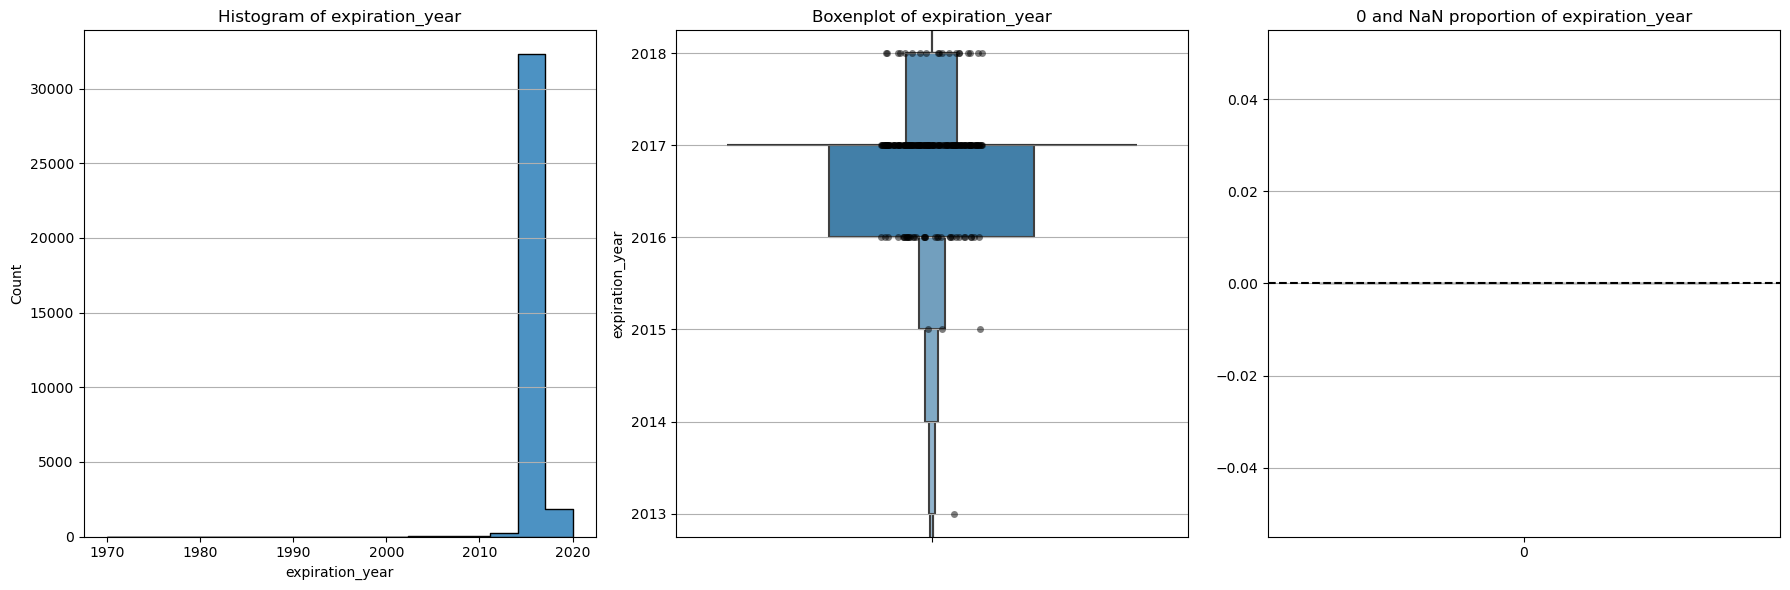

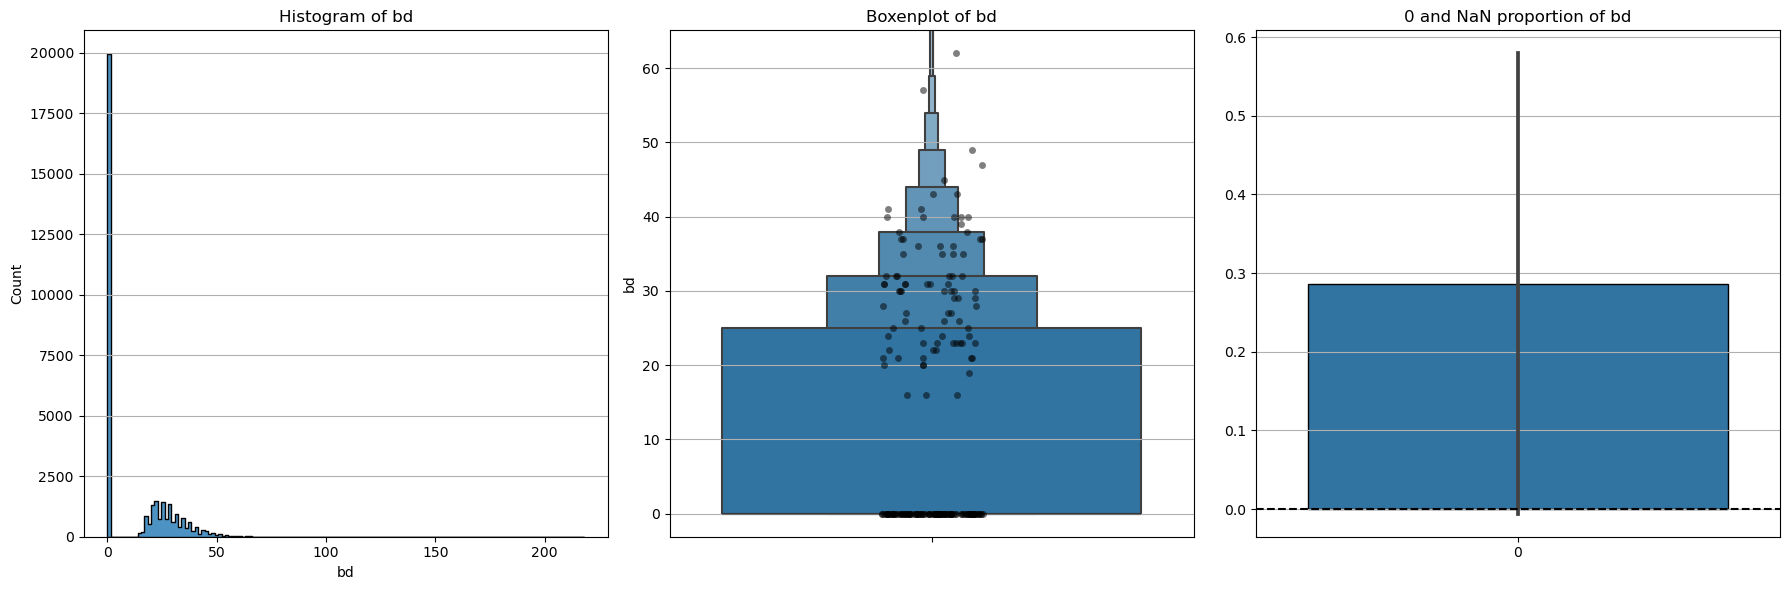

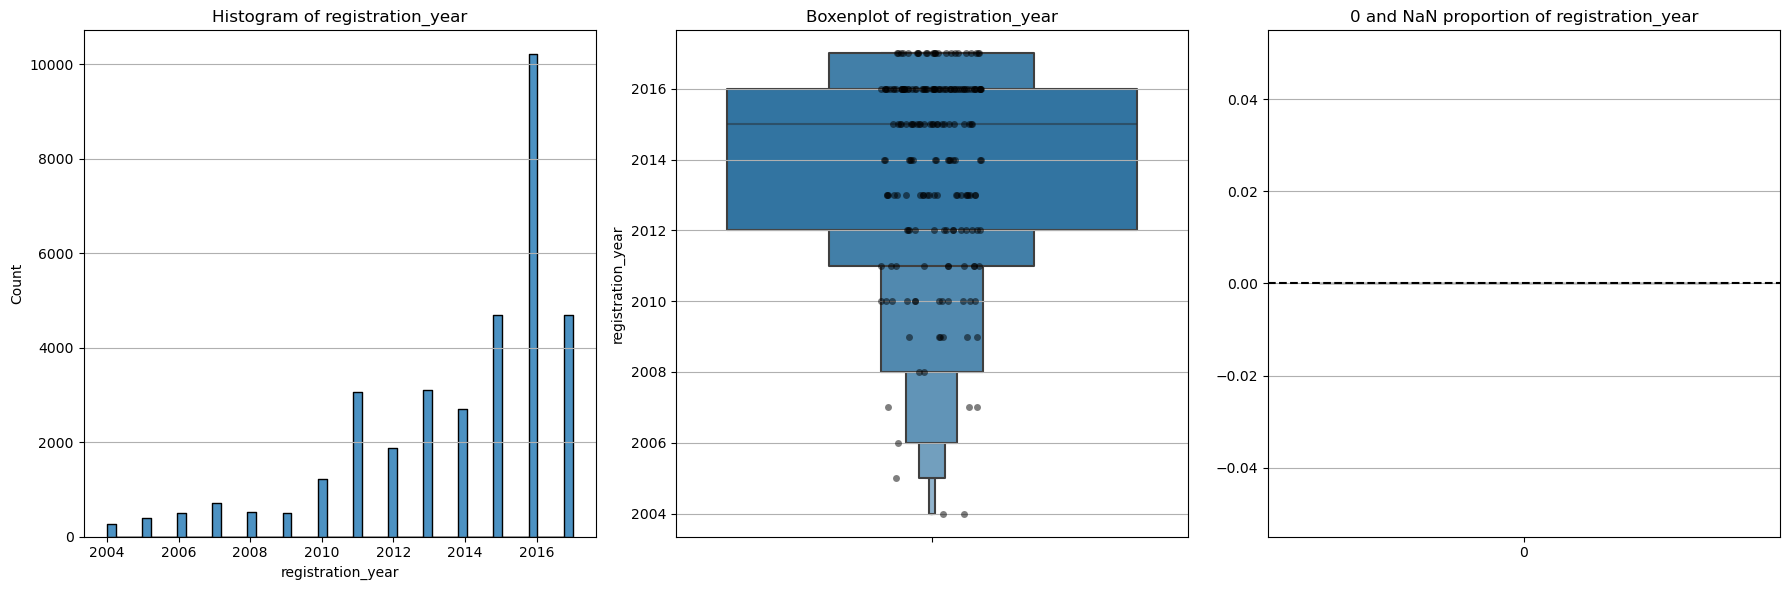

In [54]:
plotter = DistributionPlotter(members, cols = ['city', 'bd', 'registration_year', 'registered_via', 'gender', 'expiration_year'], max_cat_thr = 0)
plotter.plot_all()

Заметим, что тут есть два временных признака, так что уже можно взять разницу этих временных признаков, а также посмотреть на разницу этих временных признаков с аналогичными из других датасетов. Также из этих распределений понятно, какие колонки являются категориальными. Также, заметим, что в данных существует выброс в распределении возраста, посмотрим на него внимательнее. 

In [55]:
members['bd'].value_counts()

bd
0     19932
27      751
22      751
24      740
26      719
      ...  
70        1
3         1
97        1
76        1
10        1
Name: count, Length: 94, dtype: int64

Очевидно, что это просто пропущенный возраст, поэтому лучше заполним его NaN-ом, чтобы наша модель случайно не отрезала их в бустинге. Также введем отдельный признак изначального NaN-на, а не 0

In [56]:
members['has_nan_not_0'] = pd.isna(members['bd'])

In [57]:
members.bd[members['bd'] == 0] = np.NaN

In [58]:
members['registered_via'].value_counts()

registered_via
4     11392
7      9433
9      8628
3      4879
13       70
16        1
Name: count, dtype: int64

Данный признак также является категориальным, как и колонка пола.

Также посмотрим, все ли пользователи у нас уникальные или есть повторяющиеся

In [59]:
assert members['msno'].nunique() == members.shape[0]

Как видно, повторений нет

## Рассмотрим song_extra_info

In [60]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [61]:
song_extra_info['name'].value_counts()

name
Intro                                                         1734
Silent Night                                                  1088
White Christmas                                               1018
Jingle Bells                                                   964
Ave Maria                                                      792
                                                              ... 
O-he-do je                                                       1
Eyes Of Love                                                     1
Balada Boa (Tché Tcherere Tché Tché)                             1
By the Window                                                    1
If You Can't Live Without Me Then Why Aren't You Dead Yet?       1
Name: count, Length: 1168978, dtype: int64

In [62]:
song_extra_info.isrc.value_counts()

isrc
GBPS81518952    207
GBPS81527416    205
GBPS81518950    195
GBPS81518680    195
GBPS81518682    194
               ... 
UKEA31600141      1
USA371564975      1
DEPZ69335358      1
FRZ050000138      1
DEPZ69316095      1
Name: count, Length: 1806825, dtype: int64

Этот признак - уникальный код песни, поэтому распарсим его

In [63]:
def song_extra_pipepline(df):

    def isrc_to_year(isrc):
        '''
        Получили год
        '''
        if type(isrc) == str:
            if int(isrc[5:7]) > 17:
                return 1900 + int(isrc[5:7])
            else:
                return 2000 + int(isrc[5:7])
        else:
            return np.nan
    
    def country(isrc):
        '''
        Получили страну
        '''
        if type(isrc) == str:
            return isrc[:2]
        return np.nan

    def reg_code(isrc):
        '''
        Получили код регион
        '''
        if type(isrc) == str:
            return isrc[2:5]
        return np.nan

    def des_code(isrc):
        '''
        Получили уникальный код песни, изначально он должен быть цифрой, поэтому, если это не так, то прокине нан
        '''
        if type(isrc) == str and isrc[7:].isdigit():
            return int(isrc[7:])
        return np.nan


    df['song_year'] = song_extra_info['isrc'].apply(isrc_to_year)

    df['song_country'] = song_extra_info['isrc'].apply(country)

    df['reg_code'] = song_extra_info['isrc'].apply(reg_code)

    df['des_code'] = song_extra_info['isrc'].apply(des_code)

    df['isrc_missing'] = (df['song_country'] == 0) * 1.0

    df_ = df.drop(['isrc', 'name'], axis = 1)

    return df_

        


In [64]:
song_extra_info_new = song_extra_pipepline(song_extra_info)

In [65]:
song_extra_info_new.head()

,song_id,song_year,song_country,reg_code,des_code,isrc_missing
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0,TW,UM7,43.0,0.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0,QM,ZSY,15.0,0.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0,TW,A53,87303.0,0.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0,US,SM1,1446.0,0.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0,TW,A47,6001.0,0.0


## Рассмотрим датасет songs

### Анализ распределений

In [66]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


Построим распределение данных

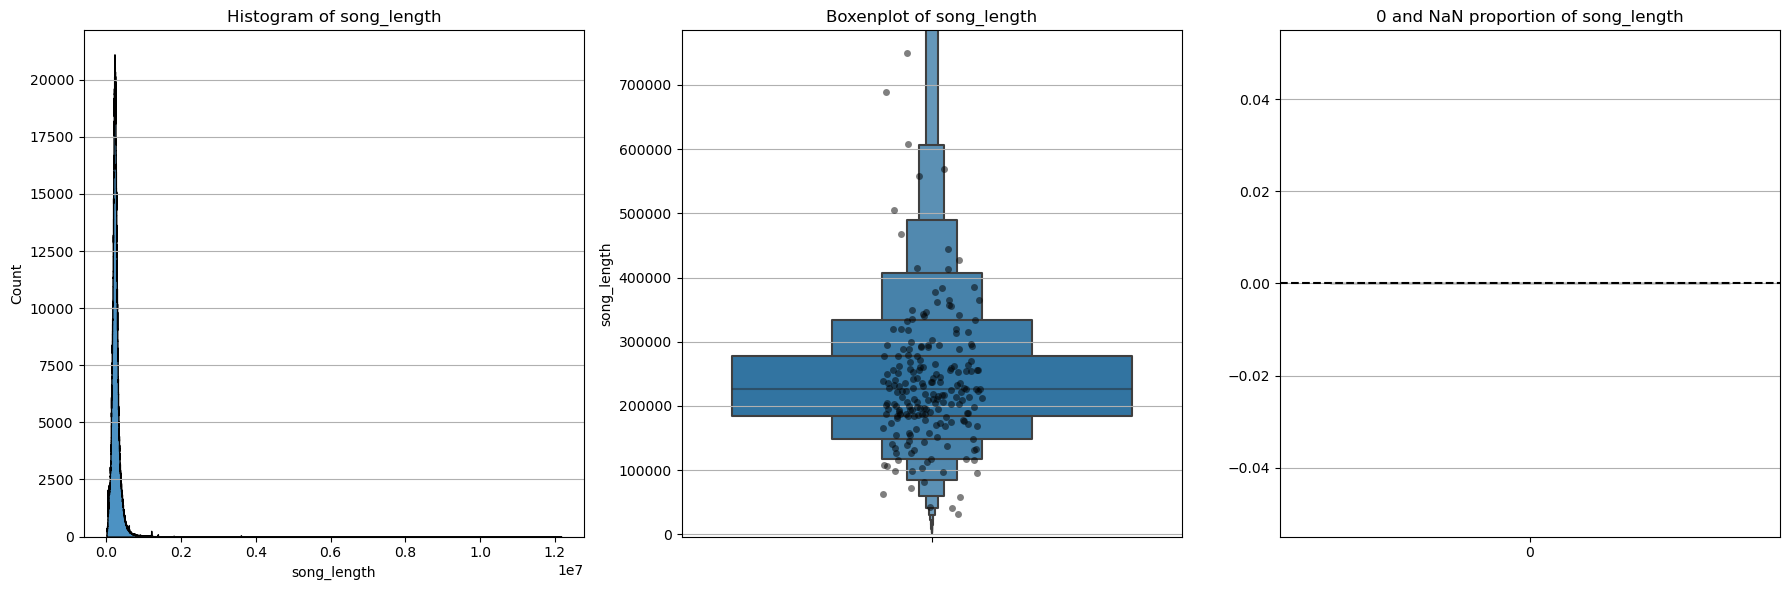

In [67]:
plotter_songs = DistributionPlotter(songs, cols = ['song_length', 'language'], max_cat_thr = 1)
plotter_songs.plot_all()

Получили довольно странные выбросы в длинне песен, но при более детальном рассмотрении я увидел, что это всякий эмбиент, который может идти 3 часа, однако те, котоорые идут около 0 секунд стоит воспринимать как баг.

<Axes: xlabel='language', ylabel='Count'>

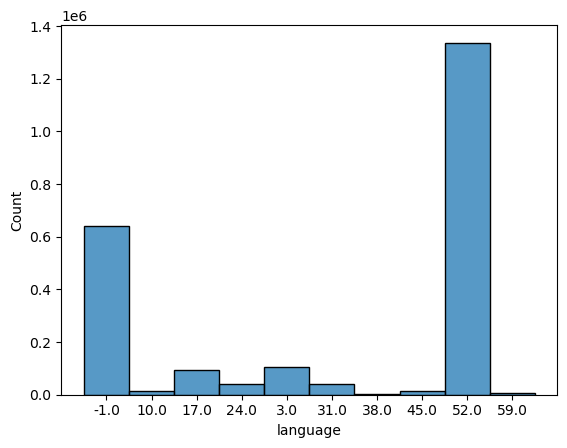

In [68]:
sns.histplot(songs, x = 'language')

Как видим, есть выброс в 2 языках - 52 и -1, как мне кажется, легко понять, что 52 - английский язык, посмотрим поближе на группу -1

Посмотрим поближе на популярные группы

In [69]:
songs[songs.language.to_numpy() == '52.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0
14,an6EdIr+Z+KbqIVQiXn5PKkcXncefQ7hhWONseRuub4=,282697,359,Coldplay,Chris Martin| Guy Berryman| Jonny Buckland| Mi...,NaN,52.0
15,J2MFmy8iF94mExWfRWE3KxsMZB+ZIedV5liqZoSrERQ=,221518,359,Maggie Rogers,Maggie Rogers| Nicholas Das,NaN,52.0
20,IV8kTOBKcUoO4fINEi+VTYzr7TdyM/kin+gapgzygco=,228993,465,Katy Perry,Katy Perry| Max Martin| Lukasz Gottwald| Henry...,NaN,52.0


Действительно английский

In [70]:
songs[songs.language.to_numpy() == '-1.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
12,fAZLdfQaLG76a6Ei4alt1eSjBM9rshQkiQEC6+n+y08=,180871,726,Littlesong,Michael William Balfe,NaN,-1.0
18,JcHIgDP5ivyqYIn7RxfXM13eWwOzcoxkWosSauz6RbU=,374027,726,White Noise,NaN,NaN,-1.0
28,+dOlHQGlsiHPbG1cMYsoFVsAi05YgsGfeEzsdS16yec=,368441,1609,Marvin Gaye & Kygo,Marvin Gaye| Odell Brown| David Ritz,Marvin Gaye| Odell Brown| David Ritz,-1.0
44,/pNJtPeT5RixL9cwAScQ83XG6lzNjQbxXdz9Bxm3UCk=,954851,873,蘇曼竹巴仁波切,公版,公版,-1.0
54,vLLKr+iN+vepbTD6W2kDXHvuqmGiXGdXRRHLjRp0pCQ=,300257,873,原力歌手,王苒馨,公版,-1.0


Как видно, никакой закономерности нет, так что это просто ошибка данных

In [71]:
songs[songs.language.to_numpy() == '3.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0


Это китайский

In [72]:
songs[songs.language.to_numpy() == '17.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
25,SONqxocCptA85J/tJ1hGlTVbQxs+x1gokyes79xZFO0=,266788,1609,Kyary Pamyu Pamyu (きゃりーぱみゅぱみゅ),Yasutaka Nakata,Yasutaka Nakata,17.0
71,q0uoD+Tb1VDtc5Srw0G3wJnxFeUTM5rVoPzvwMszedE=,323605,465,Yui Aragaki (新垣結衣),Kenji Kubo| Kubo Kenji,Iwasato Yuho| Yuho Iwasato,17.0
80,SWVyLXlJtVtH6RT55x5SAk9GizXu4KUS9jPFfinsrEQ=,215519,NaN,ジブリサウンドトラック,久石 譲,覺 和歌子 Wakako Kaku,17.0
85,R/AOsz3pUshdY/o9mkBoLbJKMxQlf7cgjvEEOifJwkI=,284525,1259,BANGTAN BOYS,UTA|HIRO|RAP MONSTER|SUGA|J-HOPE|PDOGG,PDOGG|UTA|HIRO|RAP MONSTER|SUGA|J-HOPE,17.0


Это японский

In [73]:
songs[songs.language.to_numpy() == '24.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
30,i0JD8QBIkZtIoe0NvVQkGxDZGdRYPQ8woEL7dcaloxE=,212276,465,謝霆鋒 (Nicholas Tse),NaN,NaN,24.0
55,IouVtHBa0SRl7CqYwGkyvN7Vu7drl0Llq9swfIXwLx8=,208004,465,鄭伊健 (Ekin Cheng),陳光榮,劉卓輝,24.0
92,Noeu7vuMPsE0YOVjjER8noULjFaZC7VFnRAdJ5EsHzA=,242811,465,鄭秀文 (Sammi Cheng),Gigi Leung,Keith Chan| Keith Chan Siu Kei,24.0
166,y5iBOZRuY93iBVFeRkNiBkLN4EQ3d6JPGp/yKVEsF2M=,248871,465,張國榮 (Leslie Cheung),NaN,NaN,24.0
188,mOPAuQeWUAvgjUUy025mv0X8kOyvc1bCwDgnPw7g5LU=,333206,465,Supper Moment,Supper Moment,Supper Moment,24.0


Это диалект китайского

In [74]:
songs[songs.language.to_numpy() == '31.0'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
23,FZ5/wgtMuMV0Y8gzzgQj6bH3Qpr62zRV/LwbhNBrdqk=,220056,465,BIGBANG TAEYANG,NaN,NaN,31.0
40,vzWZd7svSo4Xc/kUMEtRuAJkupQIGqcPeTqESWz84UQ=,196179,465,JUNIEL,TWO FACE | 이상호 (Lee Sang Ho),한성호 (Han Sung Ho),31.0
43,igUq5ErBzlm2Wi05YsoiyWdxd4wbHGPaFOS8kQFhoik=,228717,465,Urban Zakapa,Gwon Soonil| Park Yongin| Choi JaeMan| Jo HyunAh,Gwon Soonil| Park Yongin| Choi JaeMan| Jo HyunAh,31.0


Это корейский, но так как это кейпоп песни, которые также популярны в английской среде попробуем ввести признак - язык, понятный на западе

Подводя итог, можно добавить признак является ли язык азиатским, а также обьединить все языки, понятные китайцам

### Добавление признаков

In [75]:
def pipeline_songs(df):

    '''
    Функция, которая создает фичи в нашем датасете
    '''
    def genre_id_count(x):
        '''
        Функция, считающая число жанров песни
        '''
        if x == np.nan:
            return 0
        else:
            return x.count('|') + 1
    
    def lyricist_count(x): 
        '''
        Функция, считающая число исполнителей песни

        '''
        if x == np.nan:
            return 0
        else:
            return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

    def composer_count(x):
        '''
        Функция, считающая число композиторов песни
        '''

        if x == np.nan:
            return 0
        else:
            return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    
    def is_featured(x):
        '''
        Функция, которая проверяет является ли песня фитом
        '''
        if 'feat' in str(x) :
            return 1
        return 0
    
    def artist_count(x):
        '''
        Фунция считает число артистов в песне
        '''
        if x == np.nan:
            return 0
        else:
            return x.count('and') + x.count(',') + x.count('feat') + x.count('&')
    
    def song_lang_boolean(x):
        '''
        Разпарсим языки, как было сказано выше
        '''
        if '31.0' == str(x) or '17.0' == str(x) or '24.0' == str(x) or '3.0' == str(x):
            return 1
        elif "52.0" == str(x) or '31.0' == str(x):
            return 2
        return 0
    
    def song_chinese(x):
        '''
        Разпарсим языки, как было сказано выше
        '''
        if '3.0' == str(x) or "24.0" == str(x):
            return 1
        return 0
    genre_id = np.zeros((len(songs), 4))
    for i in range(len(songs)):
        if not isinstance(songs['genre_ids'].values[i], str):
            continue
        ids = str(songs['genre_ids'].values[i]).split('|')
        if len(ids) > 2:
            genre_id[i, 0] = int(ids[0])
            genre_id[i, 1] = int(ids[1])
            genre_id[i, 2] = int(ids[2])
        elif len(ids) > 1:
            genre_id[i, 0] = int(ids[0])
            genre_id[i, 1] = int(ids[1])
        elif len(ids) == 1:
            genre_id[i, 0] = int(ids[0])
            genre_id[i, 3] = len(ids)
    df['first_genre_id'] = genre_id[:, 0]
    df['second_genre_id'] = genre_id[:, 1]
    df['third_genre_id'] = genre_id[:, 2]
    df['genre_id_cnt'] = genre_id[:, 3]
    
    
    df['genre_id_count'] = df['genre_ids'].apply(genre_id_count)
    df['lyricist_count'] = df['lyricist'].apply(lyricist_count)
    df['composer_count'] = df['composer'].apply(composer_count)
    df['is_featured'] = df['artist_name'].apply(is_featured)
    df['artist_count'] = df['artist_name'].apply(artist_count)
    df['song_lang_boolean'] = df['language'].apply(song_lang_boolean)

    df['chinese'] = df['language'].apply(song_chinese)

    return df


In [76]:
songs_new = pipeline_songs(songs)

## Исследуем Train

In [77]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


Ничего интересного обнаружить не удалось, потому что все колонки - просто категориальные, так что замерджим таблички

In [78]:
train = train.merge(songs_new, on='song_id', how='left')
test = test.merge(songs_new, on='song_id', how='left')

In [79]:
train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

In [80]:
train = train.merge(song_extra_info_new, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(song_extra_info_new, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

In [81]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [89]:
def pipeline_song_count(train, test):
    '''
    Посчитаем количество раз, которое конкретная пессня была сыграна и сколько раз она в принципе появлялась перед человеком, 
    а также индекс конверсии
    '''
    song_count = train.loc[:,["song_id","target"]]

    song_count1 = song_count.groupby(["song_id"],as_index=False).sum().rename(columns={"target":"repeat_count"})

    song_count2 = song_count.groupby(["song_id"],as_index=False).count().rename(columns = {"target":"play_count"})


    train = train.merge(song_count1, on = "song_id", how = "left")
    train = train.merge(song_count2, on = "song_id", how = "left")
    train['repeat_count/play_count'] = train['repeat_count'] / train['play_count']

    test = test.merge(song_count1, on = "song_id", how = "left")
    test = test.merge(song_count2, on = "song_id", how = "left")
    test['repeat_count/play_count'] = test['repeat_count'] / test['play_count']

    return train, test
train, test = pipeline_song_count(train, test)

## Создание псевдовремени

Поскольку песни идут для юзера в хронологическом порядке, попробуем упорядочить их и ввести псевдопризнак времени

In [90]:
from collections import defaultdict
def pipeline_timestamp(df):
    df['timestamp'] = range(len(df))
    def timestamp_map(x):
        '''
        Заведем стандартную функцию маппера для нашего времени
        '''

        if x < 7377418:
            x = (x - 0.0) / (7377417.0 - 0.0) * (1484236800.0 - 1471190400.0) + 1471190400.0
        else:
            x = (x - 7377417.0) / (9934207.0 - 7377417.0) * (1488211200.0 - 1484236800.0) + 1484236800.0

        return x
    

    
    
    df['timestamp'] = df['timestamp'].apply(timestamp_map)
    d = df.groupby('msno')['timestamp'].apply(lambda x: max(x)).to_dict()

    d_min = df.groupby('msno')['timestamp'].apply(lambda x: min(x)).to_dict()

    def time_to_max(x, y):
        return d[x] - y


    df['time_to_max'] = df[['msno', 'timestamp']].apply(lambda x: time_to_max(x.msno, x.timestamp), axis = 1)

    def time_to_min(x, y):
        return d_min[x] - y


    df['time_to_min'] = df[['msno', 'timestamp']].apply(lambda x: time_to_min(x.msno, x.timestamp), axis = 1)

    msno_list = df['msno'].values
    song_list = df['song_id'].values


    # Посчитаем количество песен того же типа, встретившихся до текущей

    msno_dict = defaultdict(lambda: 0)
    song_dict = defaultdict(lambda: 0)

    msno_till_now_cnt = np.zeros(len(df))
    song_till_now_cnt = np.zeros(len(df))
    for i in range(len(df)):
        msno_till_now_cnt[i] = msno_dict[msno_list[i]]
        msno_dict[msno_list[i]] += 1
    
        song_till_now_cnt[i] = song_dict[song_list[i]]
        song_dict[song_list[i]] += 1

    df['msno_till_now_cnt'] = msno_till_now_cnt
    df['song_till_now_cnt'] = song_till_now_cnt




    df.sort_values(by = "msno", ascending= False, inplace = True)  
    df['time_diff'] = df.groupby("msno")["timestamp"].diff()
    df['time_diff'].fillna(0, inplace = True)

    df['average_time_for_song'] = df['time_diff'] / df['song_length']


    return df



train = pipeline_timestamp(train)
test = pipeline_timestamp(test)


In [91]:
def pipeline_time(df):
    '''
    Очевидно, что если песня вышла до регитрации или после выхода из сервиса, то человек послушает ее с меньшей вероятностью
    '''
    df['song_existed_before_cancel'] = (df['song_year'] <= df['expiration_year']) * 1.0
    df['song_existed_before_reg'] = (df['song_year'] <= df['registration_year']) * 1.0
    return df
train, test = pipeline_time(train), pipeline_time(test)

## Введение меры близости

Попробуем формализовать расстояние от новой песни до средней песни юзера за все время.

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
columns_for_song = [
                    'song_length', 
                    'first_genre_id',
                    'artist_count',
                    'composer_count', 
                    'genre_id_count', 
                    'lyricist_count',
                    'first_genre_id',
                    'song_lang_boolean',
                    'language',
]


def pipeline_cos(df, columns_for_song, hue="msno"):
    def my_cos(row):
        raw_1 = row.drop("msno").values
        raw_2 = grouped.loc[row['msno']].values
        to_norm = (np.linalg.norm(raw_1) * np.linalg.norm(raw_2))
        return raw_1 @ raw_2 / to_norm


    df_ = df[columns_for_song].copy()
    for column in columns_for_song:
        df_[column] = df_[column].astype(np.number)
        df_[column].fillna(1e5, inplace=True)

    df_['msno'] = df[hue]  # Сохраняем столбец 'msno' в DataFrame df_

    for column in columns_for_song:
        df_[column] = (df_[column] - df_[column].mean()) / df_[column].std()

    grouped = df_.groupby(hue).apply(lambda x: x.drop(hue, axis=1).mean())

    df['cosine_distance_to_avg'] = df_.apply(my_cos, axis=1)

    return df




    
    

train = pipeline_cos(train, columns_for_song= columns_for_song)
#test = pipeline_cos(test, columns_for_song= columns_for_song)

<Axes: xlabel='cosine_distance_to_avg', ylabel='Count'>

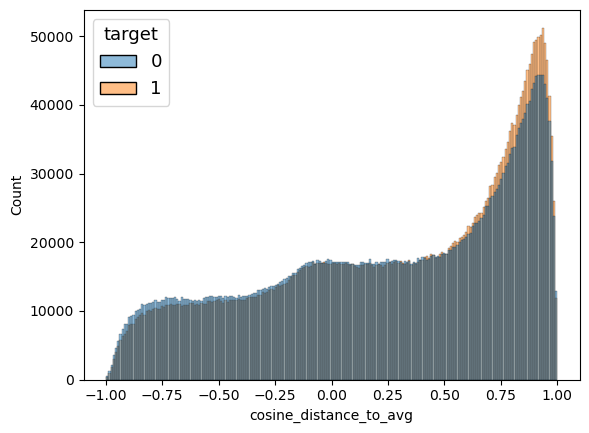

In [100]:
sns.histplot(train, x = 'cosine_distance_to_avg', hue = 'target')

Получили, что таргет и тест распределены почти одинаково для косинусного расстояния.

## Чистка мусора

Поскольку у нас накопилось много данных, почистим их, чтобы ядро не умирало

In [101]:
import gc

gc.collect()
del members
del song_extra_info
del songs_new

Сохраним датасеты, чтобы каждый раз не прогонять полный пайлайн

In [102]:
train.to_csv("train_with_cos.csv")
test.to_csv("test_with_cos.csv")

# Подготовка валидации и обучения модели

### бейслайн

In [104]:
X_train = train.drop(['target'], axis=1)
y_train = train['target'].values


X_test = test.drop(['id'], axis=1)
ids = test['id'].values

In [106]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [107]:
group_train = X_tr.groupby("msno")['msno'].count().to_numpy()
group_val = X_val.groupby("msno")['msno'].count().to_numpy()
lgb_tr = lgb.Dataset(X_tr.drop(['msno', 'song_id'], axis=1), y_tr, group=group_train)
lgb_val = lgb.Dataset(X_val.drop(['msno', 'song_id'], axis=1), y_val, group=group_val)

Посмотрим на распределение таргета, чтобы определить существует ли дизбаланс классов

In [108]:
np.unique(y_train, return_counts= True)

# Классы получились сбалансированными, поэтому в параметрах модели не будем указывать никакой neg_fraction

(array([0, 1], dtype=uint8), array([3662762, 3714656]))

### Попробуем для начала lightgbm Ranker

In [109]:
model_rank = lgb.LGBMRanker(
    objective="rank_xendcg", # рассмотрим функцию потерь, которая напрямую максимизирует ndcg
    metric="ndcg", # рассмотрим метрику, которая необходима в задании, чтобы удобноо было получать скор на валидации сразу из mlflow
    n_jobs = -1,
    learning_rate = 0.15,
    num_boost_round = 300,
    boosting = "dart", # мне нравится дарт, потому что, несмотря на более медленную работу получается лучший результат
    bagging_fraction = 0.95,
    bagging_freq = 1,
    bagging_seed = 1,
    feature_fraction = 0.9,
    random_state=42,
    verbose = -1,
)

In [ ]:
prompt = "baseline_3"
with mlflow.start_run(run_name="lgb_single_" + prompt, experiment_id=exp.experiment_id) as run:
    model_rank.fit(
        X=X_tr.drop(["msno", "song_id"], axis = 1),
        y=y_tr,
        group=group_train,
        eval_set=[(X_val.drop(["msno", "song_id"], axis = 1), y_val)],
        eval_group=[group_val],
        eval_at=[20],
        callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(stopping_rounds=5)]
    )

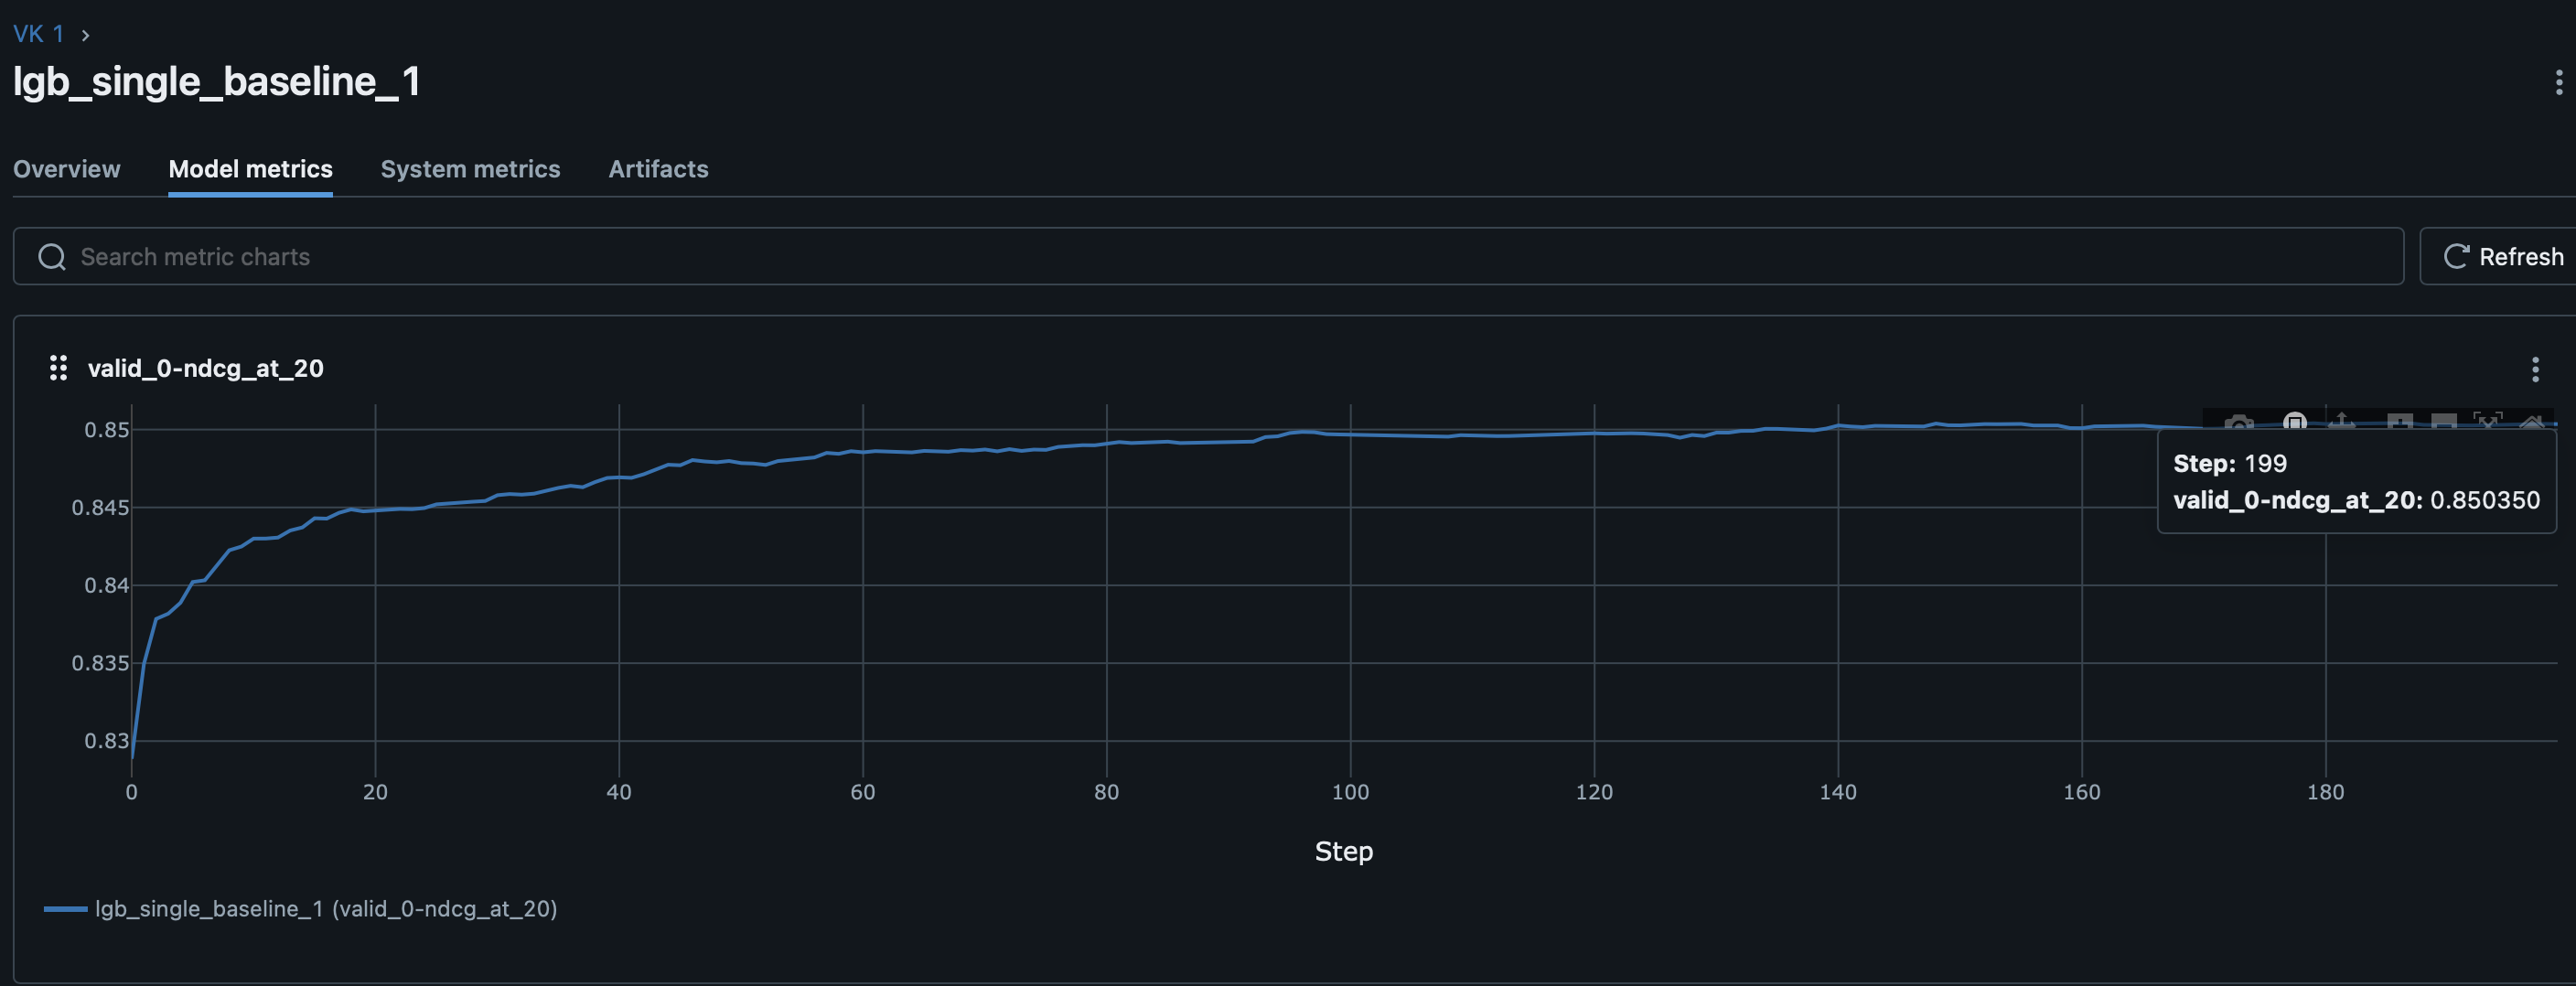

Это самый первый ран, будем использовать его как бейзлайн

## Улучшения и другие раны

Здесь и далее буду рассказывать как улучшался бейзлайн

1. После добавления косинусного расстояниия скор почти не улучшился

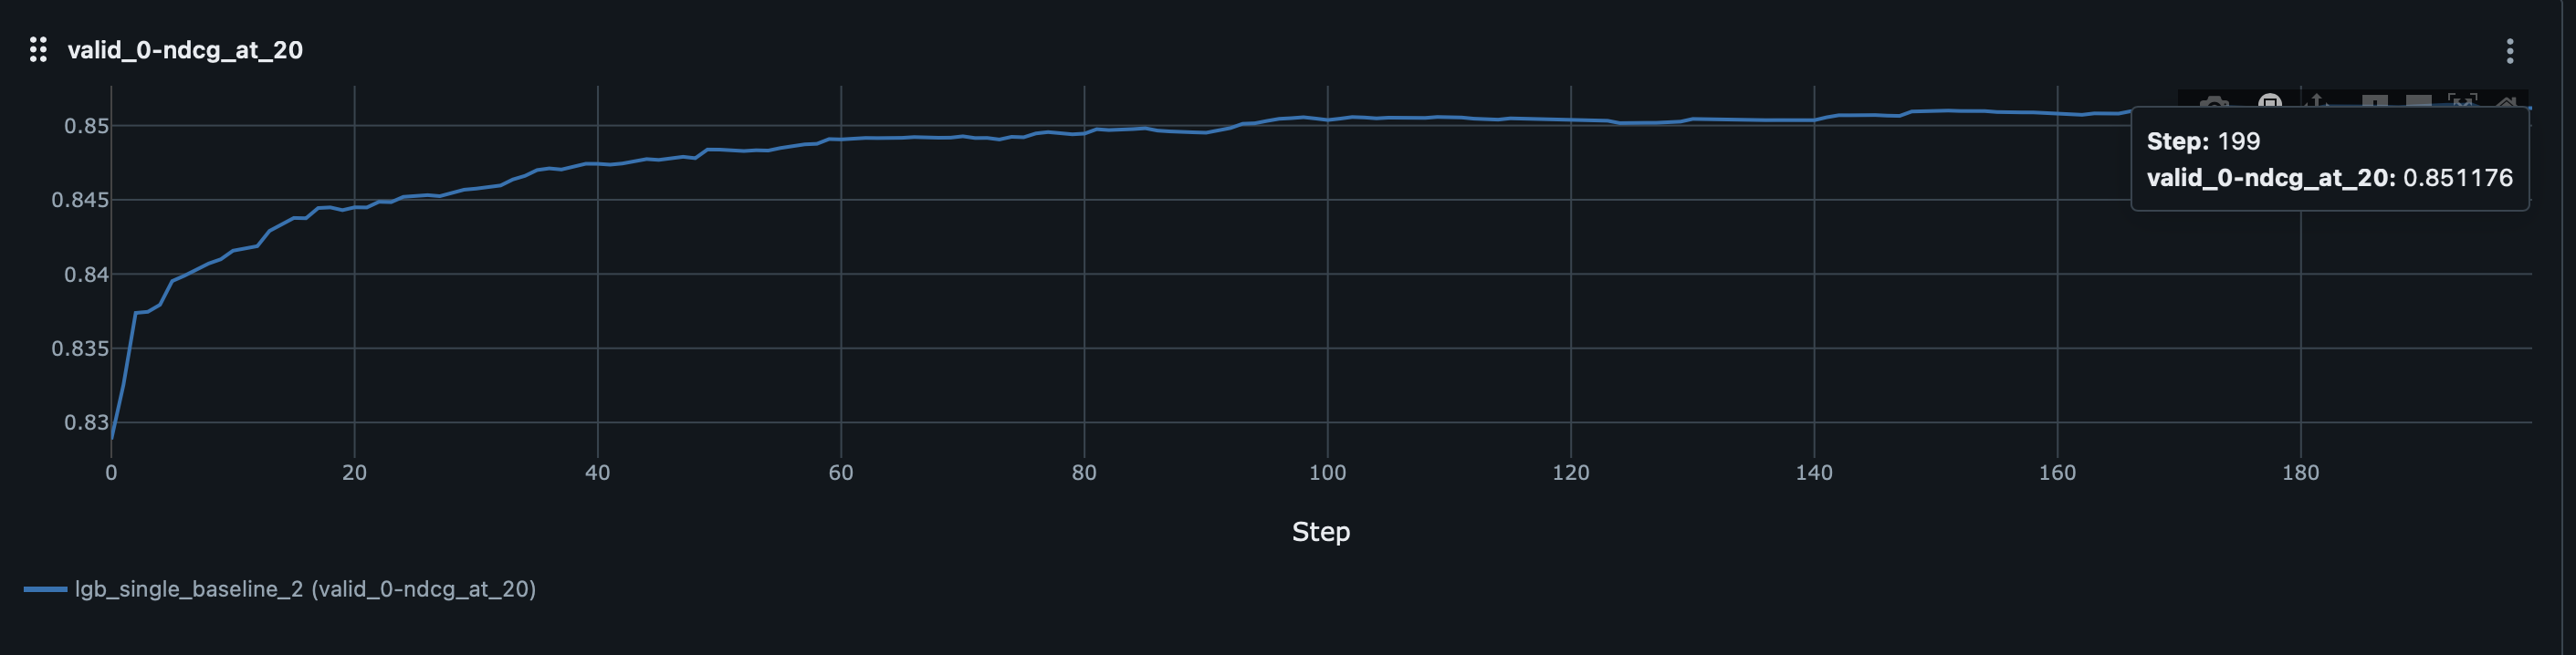

2. Я улучшил признак косинусного расстояния, а также добавил признак количества проигрышей песни и количество реплеев, а также их отношения. Также я добавил признаки языков(китайкие и азиатские)

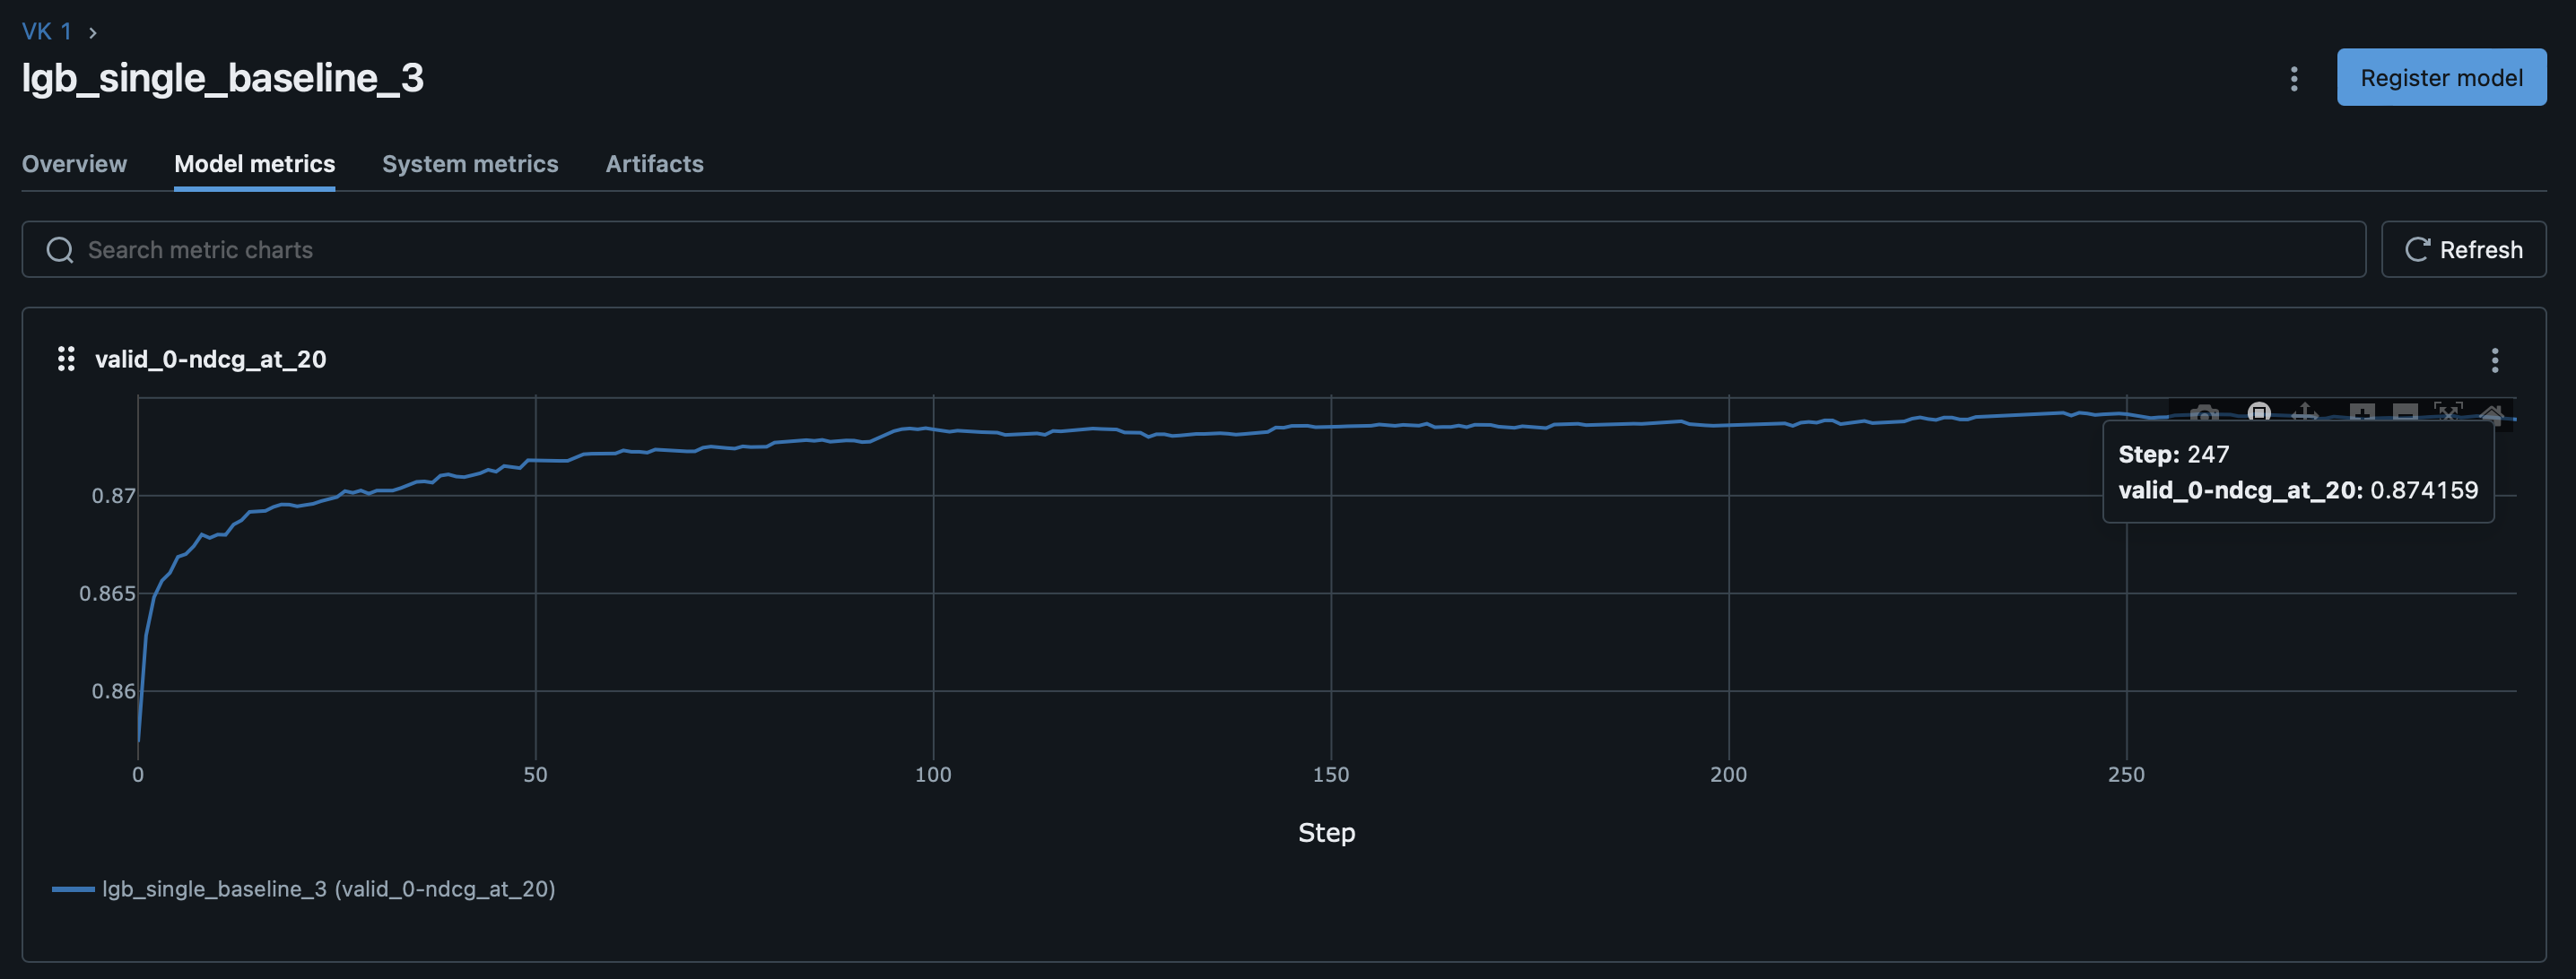

## Попробуем получить результат нейронной сети RankNet, после чего добавить ее результаты в бустинг

Нейронку я обучаю в другом файле, так что тут просто прочитаю эмбеддинг

In [2]:
train = pd.read_csv("train_with_cos.csv")
X_train = train.drop(['target'], axis=1)
y_train = train['target'].values

In [3]:
nn_pred = pd.read_csv("nn_pred.csv")

In [12]:
X_train['nn_pred'] = nn_pred['nn_pred']

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
group_train = X_tr.groupby("msno")['msno'].count().to_numpy()
group_val = X_val.groupby("msno")['msno'].count().to_numpy()

for col in X_tr.columns:
    if X_tr[col].dtype == object:
        X_tr[col] = X_tr[col].astype('category')
        X_val[col] = X_val[col].astype('category')

In [13]:
model_rank = lgb.LGBMRanker(
    objective="rank_xendcg",
    metric="ndcg",
    n_jobs = -1,
    learning_rate = 0.15,
    num_boost_round = 250,
    boosting = "dart", # мне нравится дарт, потому что, несмотря на более медленную работу получается лучший результат
    bagging_fraction = 0.95,
    bagging_freq = 1,
    bagging_seed = 1,
    feature_fraction = 0.9,
    random_state=42,
    verbose = -1,
)

In [ ]:
prompt = "nn_added"
with mlflow.start_run(run_name="lgb_single_" + prompt, experiment_id=exp.experiment_id) as run:
    model_rank.fit(
        X=X_tr.drop(["msno", "song_id"], axis = 1),
        y=y_tr,
        group=group_train,
        eval_set=[(X_val.drop(["msno", "song_id"], axis = 1), y_val)],
        eval_group=[group_val],
        eval_at=[20],
        callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(stopping_rounds=5)]
    )

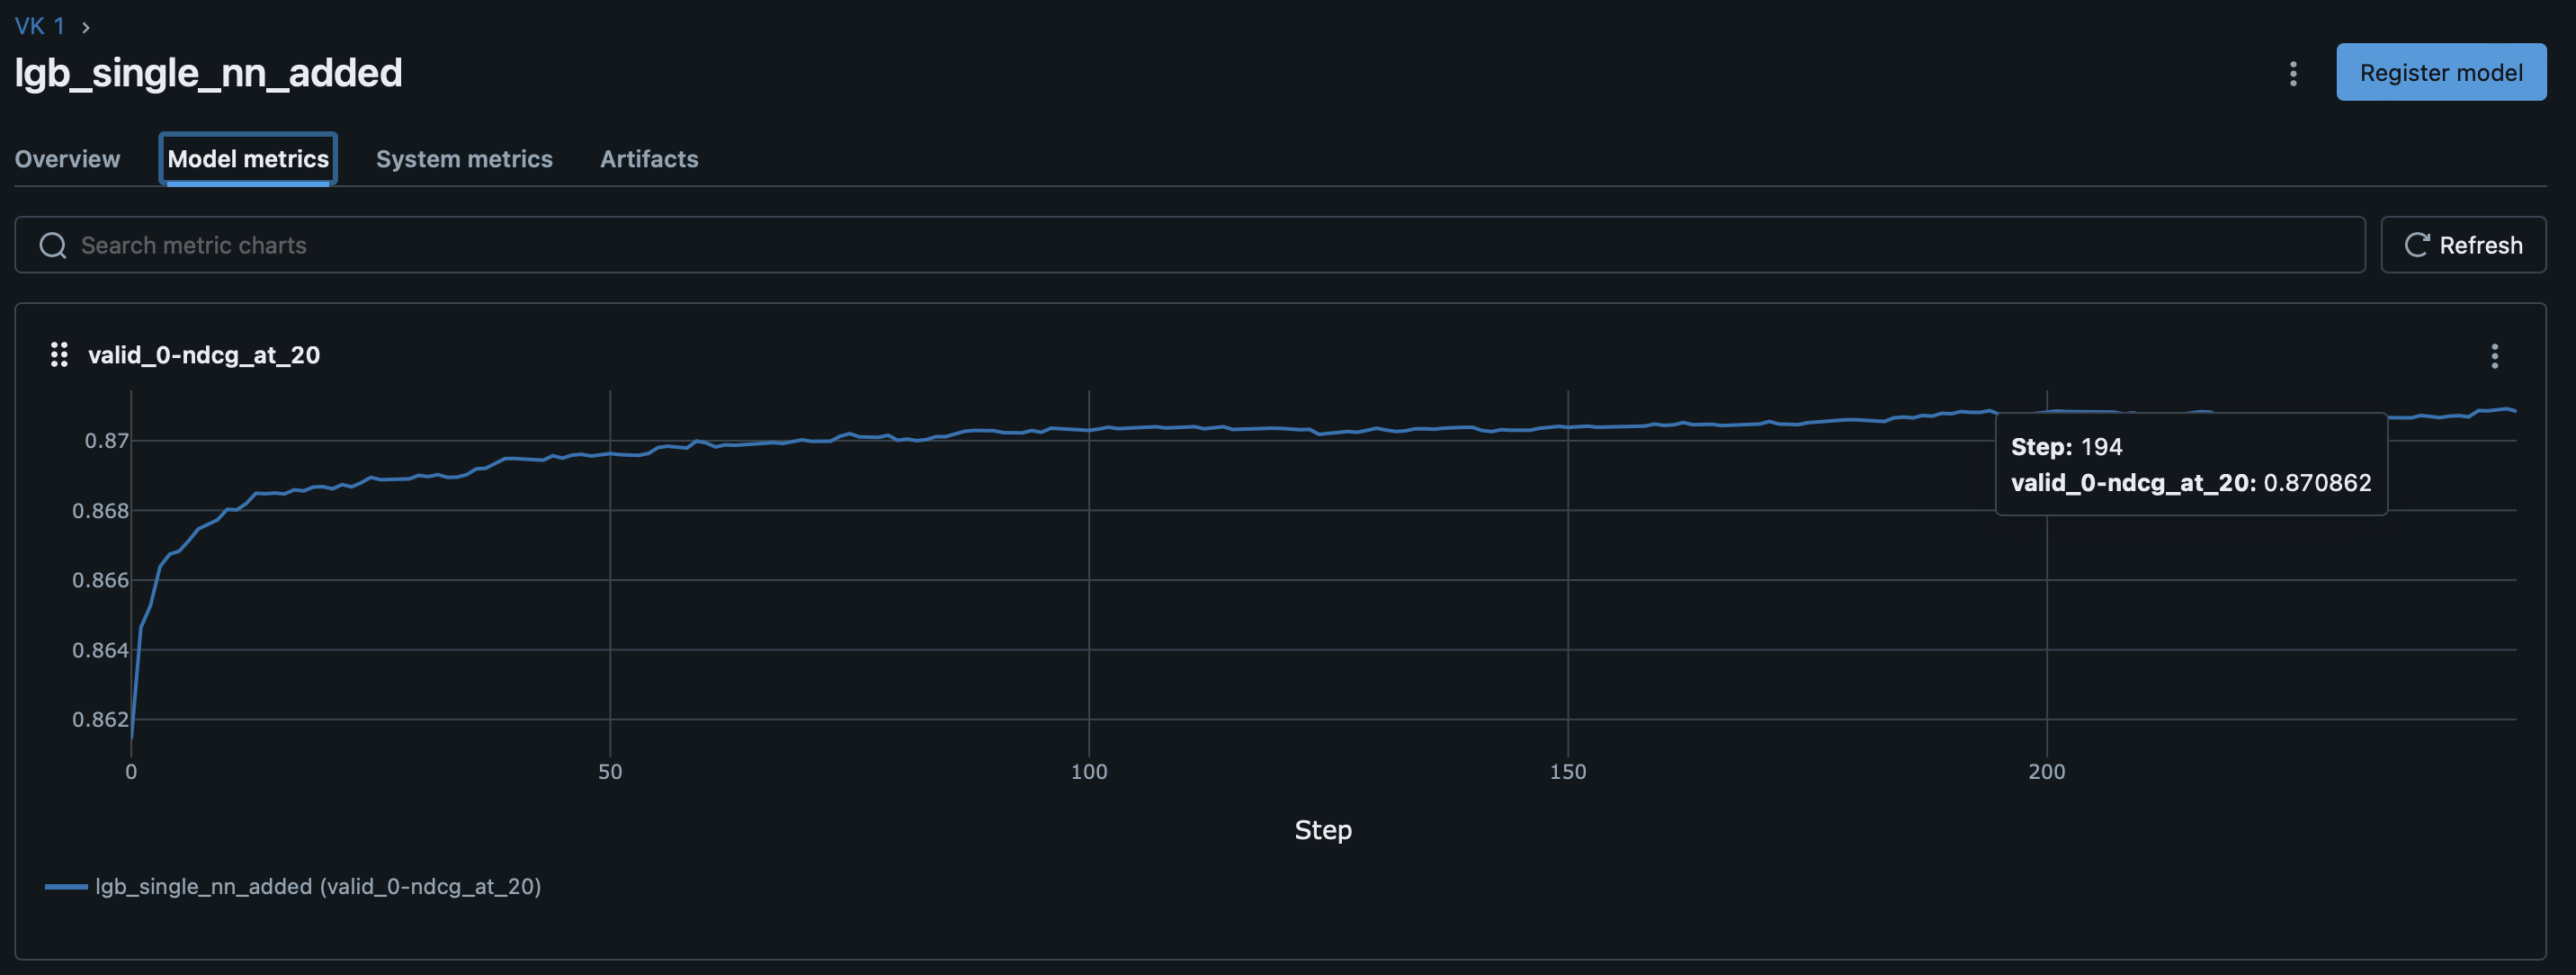

Получили небольшое ухудшение скора

Возможно это произошло из-за неправильных гиперпараметров, попробуем дать бустингу самому их подобрать

In [21]:
model_rank = lgb.LGBMRanker(
    objective="rank_xendcg",
    metric="ndcg",
    n_jobs = -1,
    num_boost_round = 250,
    boosting = "dart", # мне нравится дарт, потому что, несмотря на более медленную работу получается лучший результат
    random_state=42,
    verbose = -1,
)

In [ ]:
prompt = "nn_added_new_params"
with mlflow.start_run(run_name="lgb_single_" + prompt, experiment_id=exp.experiment_id) as run:
    model_rank.fit(
        X=X_tr.drop(["msno", "song_id"], axis = 1),
        y=y_tr,
        group=group_train,
        eval_set=[(X_val.drop(["msno", "song_id"], axis = 1), y_val)],
        eval_group=[group_val],
        eval_at=[20],
        callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(stopping_rounds=5)]
    )

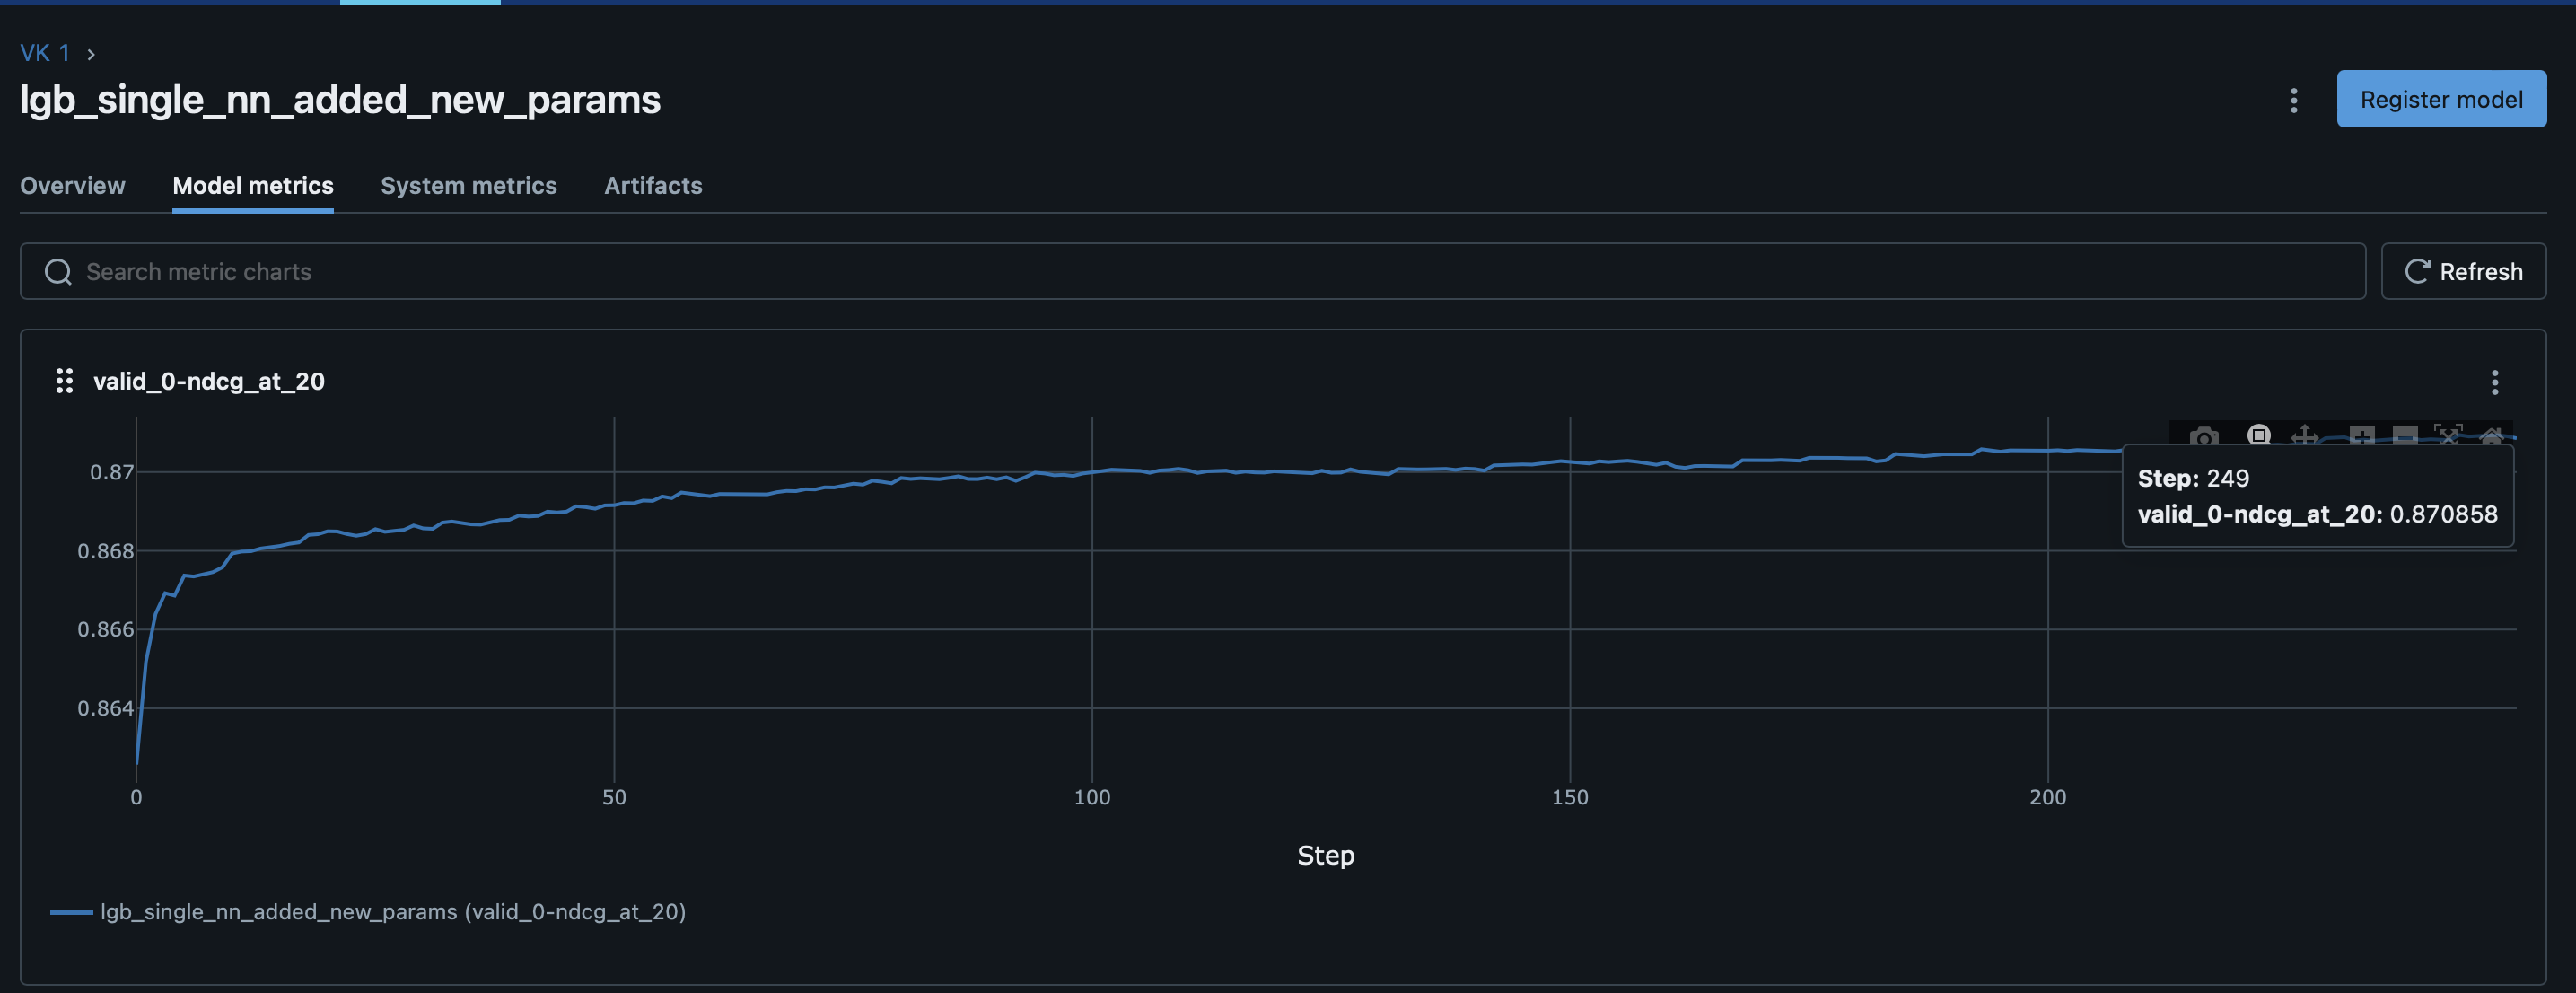

Опять получился такой же скор, так что можно сказать, что модель не улучшилась, а только ухудшилась.

## Лучший скор

Получается, что наша лучшая модель дает 0.874

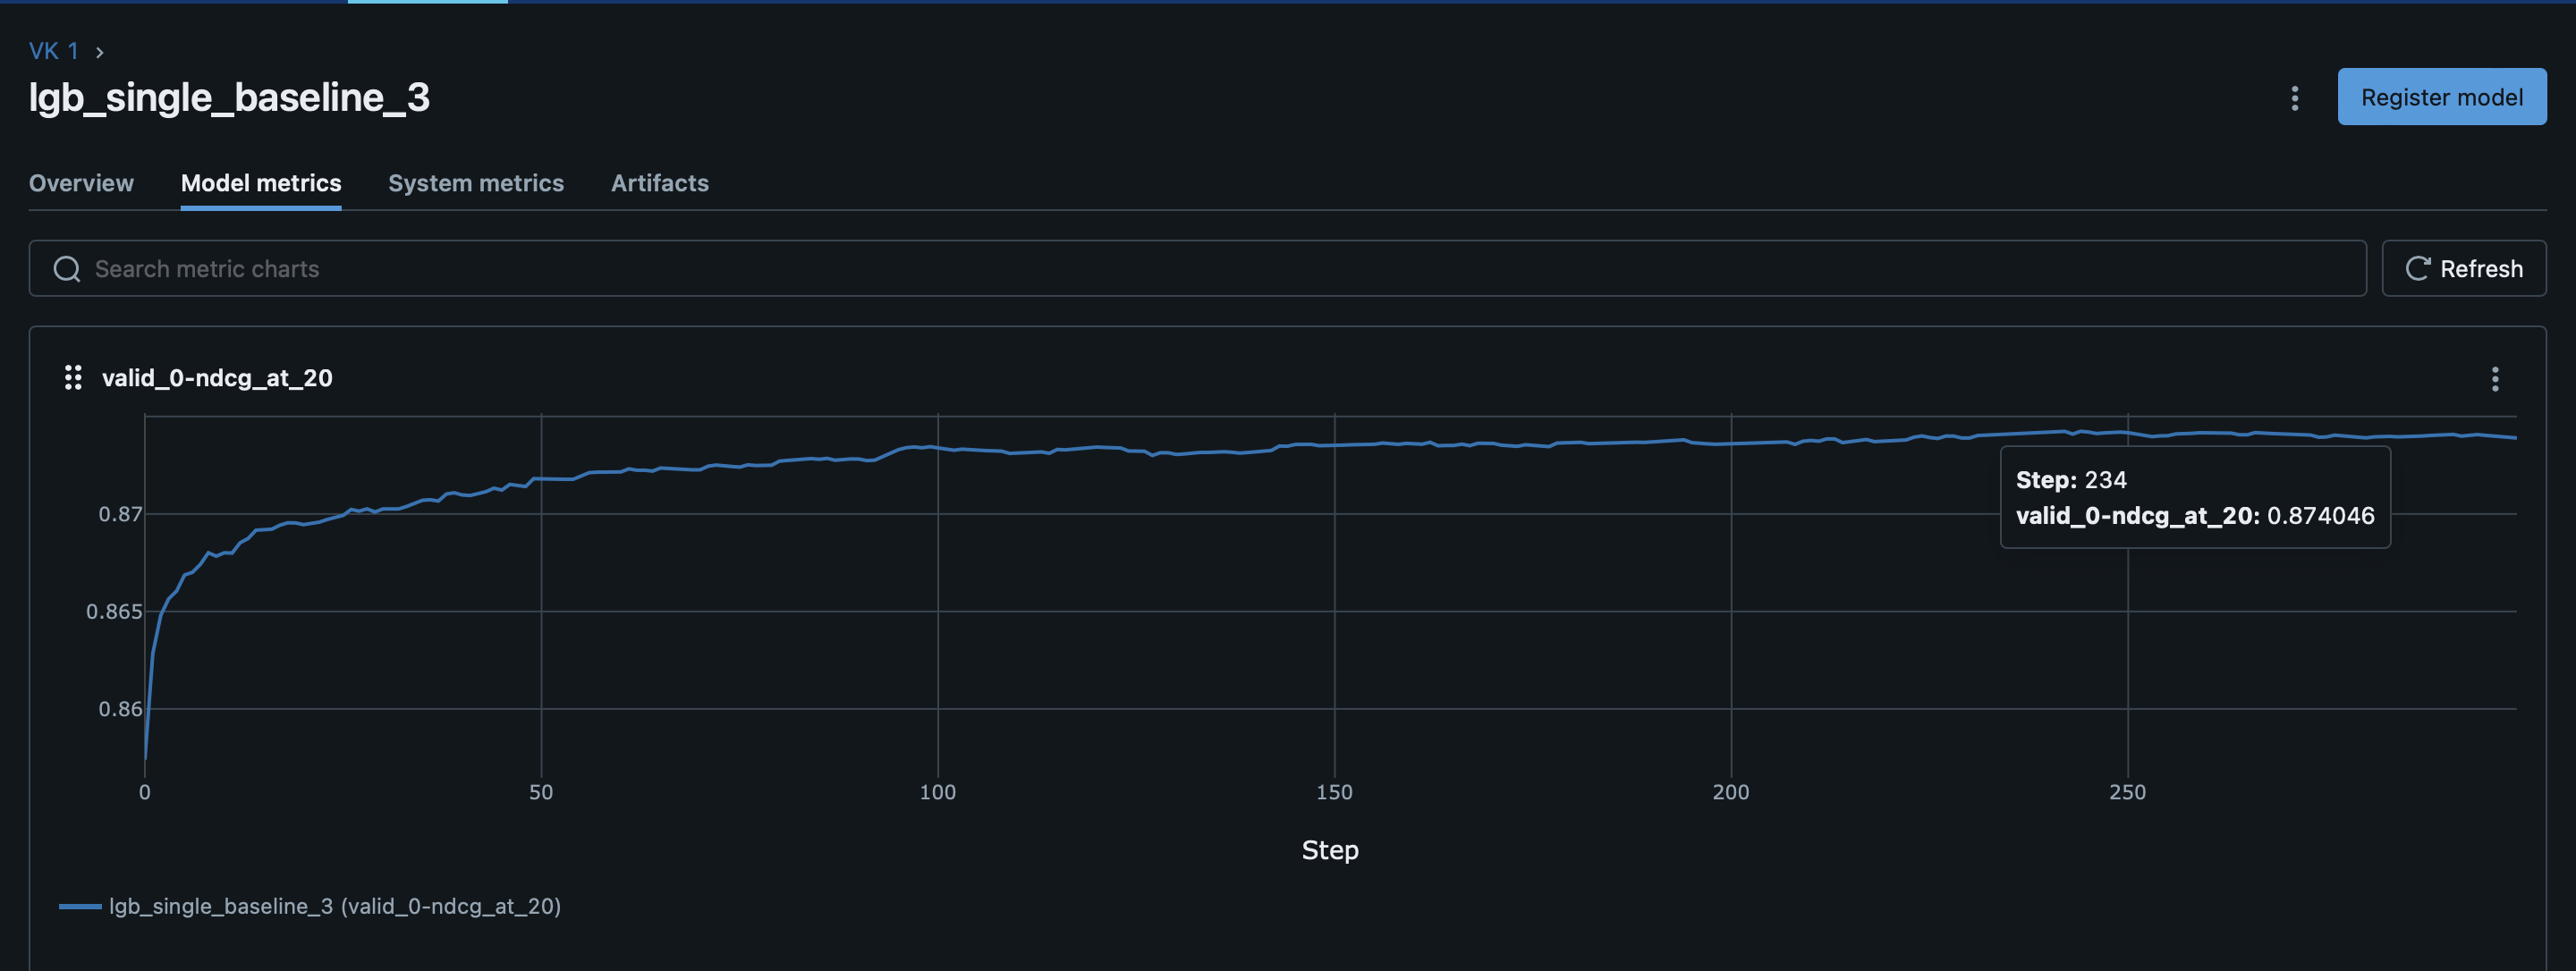

# Что можно было бы еще сделать?

1. Добавить оптюну для подбора гиперпараметров как для нейросети, так и для бустинга, но это заняло бы слишком много времени

2. Сделать лейбэнкодер для категориальных и закинуть их в нейронку, но это заняло бы также много времени

3. Если жестко максимизировать 3-4 цифру в скоре, что не особо интересно, можно было бы попробовать застакать разные бустинги, а также линейные модели по типу лог рега, knn, SVM на числовых признаках и подобрать веса оптюной, но это не так интересно, как анализ фич и обычно дает не очень большой прирост качества.